Some imports

In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
import pickle
from impartial_text_cls.impartial_text_cls import ImpartialTextClassifier
import tensorflow as tf
import tensorflow_hub as tfhub

Uncomment and run, if you don't have checkpoint downloaded

In [2]:
# tfhub.Module('https://tfhub.dev/google/bert_multi_cased_L-12_H-768_A-12/1')

Load the data

In [3]:
pd.set_option('max_colwidth', -1)

negative = pd.read_csv('data/negative.csv', header=None, sep=';', usecols=[3])
negative['class'] = 'neg'
positive = pd.read_csv('data/positive.csv', header=None, sep=';', usecols=[3])
positive['class'] = 'pos'
df = pd.concat([negative, positive], ignore_index=True, copy=False)
df = df.sample(frac=1).reset_index(drop=True)
df.rename(columns={3: 'text'}, inplace=True)
df.head(n=10)

,text,class
0,@lida_holub ты когда фото закинешь вк для всех ?(,neg
1,"И самое смешное, что у неё даже нет доказательств того, что пиздят у меня за спиной шавки)\nА у меня как раз есть интересные видео про неё..",pos
2,"@alina_royal нет, на балты, но сначала в армейку проводить человека а это к пол 8 на московские врота((",neg
3,"@sashka_dovgal Да-да,вот так я не люблю некоторых особ:)",pos
4,"Лентовцы жгут =) ""Это нтернет, детка. тут могут и на **й послать."" Конечно баян но жгут. =)",pos
5,@razvratniza короткая :(\nЯ не привыкла к таким вещам((,neg
6,"RT @qwhout90: - Папа, я замуж не выйду, — я с вами жить буду!\n- Не смей угрожать отцу!:)",pos
7,"@MeowMeowVox Да, к сожалению, иначе никак(",neg
8,"И это не смотря на то, что цены в Партер были от 5000 до 15000 рублей) В Фанзоне дела обстоят попроще: там билеты от 3500 до 4000 рублей)",pos
9,"""Миша Ковриженко Не, ну стоит беркут и титушек поблагодарить, разобрали плохие и ветхие баррикады, чтобы мы построили новые и крепкие)))))""",pos


Text preprocessing

In [4]:
def preprocess_text(text):
    # Lower text
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove @ mentions
    text = re.sub(r"@\S+", "", text)
    # Remove hashtags
    text = re.sub(r"#\S+", "", text)
    # Remove rt (retweets)
    text = re.sub("rt", "", text)
    # Remove unneeded symbols
    text = re.sub(r"[/~/`/@/#/$/%/&/-/_/+/,/.]", "", text)
    # Remove extra spaces
    text = re.sub(" +", ' ', text)
    
    return text

In [5]:
df['preprocessed_text'] = df['text'].apply(lambda x: preprocess_text(x))
df.head()

,text,class,preprocessed_text
0,@lida_holub ты когда фото закинешь вк для всех ?(,neg,ты когда фото закинешь вк для всех ?(
1,"И самое смешное, что у неё даже нет доказательств того, что пиздят у меня за спиной шавки)\nА у меня как раз есть интересные видео про неё..",pos,и самое смешное что у неё даже нет доказательств того что пиздят у меня за спиной шавки)\nа у меня как раз есть интересные видео про неё
2,"@alina_royal нет, на балты, но сначала в армейку проводить человека а это к пол 8 на московские врота((",neg,нет на балты но сначала в армейку проводить человека а это к пол 8 на московские врота((
3,"@sashka_dovgal Да-да,вот так я не люблю некоторых особ:)",pos,да-давот так я не люблю некоторых особ:)
4,"Лентовцы жгут =) ""Это нтернет, детка. тут могут и на **й послать."" Конечно баян но жгут. =)",pos,"лентовцы жгут =) ""это нтернет детка тут могут и на **й послать"" конечно баян но жгут =)"


Split to train/test

In [6]:
text_train, text_test, label_train, label_test = train_test_split(
    df['preprocessed_text'],
    df['class'],
    test_size=0.2,
    shuffle=True,
    random_state=42
)

Training (I reduced filters num and other params to make training/inference faster)

In [7]:
cls = ImpartialTextClassifier(
    bert_hub_module_handle='/tmp/tfhub_modules/2e9b4b015e19c732663e0684f163c86f1deeee30/',
    filters_for_conv2=25, 
    filters_for_conv3=25, 
    filters_for_conv4=25, 
    filters_for_conv5=25,
    hidden_layer_size=300, 
    n_hidden_layers=2, 
    batch_size=16, 
    num_monte_carlo=10,
    bayesian=True, 
    multioutput=False, 
    random_seed=42, 
    validation_fraction=0.1,
    max_epochs=100, 
    patience=5, 
    verbose=True, 
    kl_weight_init=0.5, 
    kl_weight_fin=1e-2
)
cls.fit(list(text_train)[:1000], list(label_train)[:1000])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Maximal length of text (in BPE): 64
Mean length of text (in BPE): 26.13
Median length of text (in BPE): 24

Number of known texts for training is 900.
Number of known texts for validation is 100.

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
The BERT model has been loaded from the TF-Hub.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `layer.add_weight` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Epoch 0
  Duration is 411.080 seconds
  KL weight: 0.5000

ImpartialTextClassifier(batch_size=16, bayesian=True,
                        bert_hub_module_handle='/tmp/tfhub_modules/2e9b4b015e19c732663e0684f163c86f1deeee30/',
                        filters_for_conv1=100, filters_for_conv2=25,
                        filters_for_conv3=25, filters_for_conv4=25,
                        filters_for_conv5=25, gpu_memory_frac=1.0,
                        hidden_layer_size=300, kl_weight_fin=0.01,
                        kl_weight_init=0.5, max_epochs=100, multioutput=False,
                        n_hidden_layers=2, num_monte_carlo=10, patience=5,
                        random_seed=42, validation_fraction=0.1, verbose=True)

Sample size against inference time (in sec)

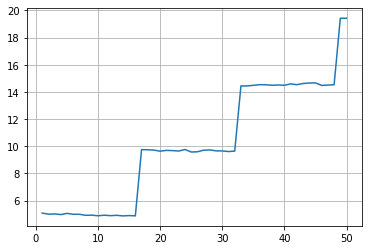

In [8]:
from sklearn.metrics import classification_report
import time
import matplotlib.pyplot as plt
%matplotlib inline

sample_sizes = []
inference_times = []
for i in range(50):
    start_time = time.time()
    cls.predict(list(text_test)[:(i + 1)])
    end_time = time.time()
    sample_sizes.append(i + 1)
    inference_times.append(end_time - start_time)
plt.plot(sample_sizes, inference_times)
plt.grid()

As we can see, model is pretty slow on inference. Let's see what happens on small fraction of test data

In [9]:
start_time = time.time()
y_pred = cls.predict(list(text_test)[:1000])
end_time = time.time()
print('Inference time: {} seconds'.format(end_time - start_time))
print(classification_report(list(label_test)[:1000], y_pred))

Inference time: 306.63769936561584 seconds
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
         neg       0.96      0.95      0.95       489
         pos       0.96      0.95      0.96       511

    accuracy                           0.95      1000
   macro avg       0.64      0.63      0.64      1000
weighted avg       0.96      0.95      0.96      1000



/home/rdalex/venv3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Saved the model

In [12]:
with open('trained_models/bert_bayesian.pkl', 'wb') as fp:
    pickle.dump(cls, fp)